In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

The Calogero-Moser Derivative Nonlinear Schrodinger equation is
$$iu_t + u_xx + 2 D_+ (|u|^2)u = 0.$$
After making the gauge transformation
$$v(x) := u(x)e^{-\frac{i}{2} \int_{-\infty}^x |u(y)|^2 dy},$$
we arrive at the equivalent equation
$$i v_t + v_{xx} + |D| (|v|^2) v - \frac{1}{4} |v|^4 v = 0.$$
Letting $A$ and $B$ be operators such that $Av = iv_{xx}$ and $Bv = i(|D|(|v|^2) - \frac{1}{4}|v|^4)v$, then we have
$$v_t = (A + B)v,$$
so that
$$v(t) = e^{t(A+B)}v_0.$$
To compute $e^{tA}$, we need to solve the linear Schrodinger equation
$$v_t = iv_{xx},$$
which

In [13]:
def gauge_transform(u):
    """Apply Tao's gauge transform"""
    v = u * np.exp(-0.5j * np.cumsum(np.abs(u)**2) * dx)
    return v

def linear_propagator(v, dt):
    """Return e^{dt A} v"""
    v_hat = np.fft.fft(v)
    v_hat *= np.exp(-1j * dt * xi**2)
    v_new = np.fft.ifft(v_hat)
    return v_new

def abs_deriv(f):
    """Compute |D|f"""
    f_hat = np.fft.fft(f)
    f_hat *= np.abs(xi)
    f_new = np.fft.ifft(f_hat)
    return f_new

def nonlinear_propagator(v, dt):
    """Return e^{dt B} v.  TODO: implement this"""
    v_new = v * np.exp(1j * dt * (abs_deriv(np.abs(v)**2) + np.abs(v)**4))
    return v_new

def split_step(v, dt):
    """Do one timestep using split step method"""
    v_new = linear_propagator(v, dt/2)
    v_new = nonlinear_propagator(v, dt)
    v_new = linear_propagator(v, dt/2)
    return v_new

def evolve(v_0, T, dt, animation_steps):
    v_tmp = np.copy(v_0)
    
    N_t = int(T / dt)
    N_t_anim = int(N_t/animation_steps)
    v_anim = np.empty(shape=(N_t_anim, N_x), dtype=complex)
    t_anim = np.arange(0, T, dt)[::animation_steps]
    
    for i in tqdm(range(N_t)):
        if i % animation_steps == 0:
            v_anim[int(i / animation_steps)] = v_tmp
        v_tmp = split_step(v_tmp, dt)
    return v_anim, t_anim

def animate(f, t, x):
    fig, ax = plt.subplots()
    
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(0, np.max(np.abs(f)))
    
    line, = ax.plot(x, np.abs(f[0]))

    def update(frame):
        line.set_ydata(f[frame])
        return line,
    
    animation = FuncAnimation(fig, update, frames=len(t), interval=50, blit=True)
    
    plt.show()
    
    return animation

def two_soliton(t, x, gamma_1, gamma_2, rho, lamb, phi):
    return np.exp(1j * phi) * np.sqrt(2 * rho) * (gamma_2 + 2 * lamb * t + (1j / lamb) - x) / (x**2  - (gamma_1 - 1j*rho + gamma_2 + 2 * lamb * t) * x + (gamma_1 - 1j * rho) * (gamma_2 + 2 * lamb * t) - lamb**(-2))

def mass(v):
    return np.sum(np.abs(v)**2)

def pi_plus(v):
    v_hat = np.fft.fft(v)
    v_hat *= np.where(xi >= 0, 1, 0)
    v_new = np.fft.ifft(v_hat)
    return v_new

def energy(v):
    integrand = np.gradient(v) / dx - 1j * pi_plus(np.abs(v)**2) * v
    return 0.5 * np.sum(np.abs(integrand)**2)

In [3]:
x_0 = -100
x_1 = 100
dx = 0.001

x = np.arange(x_0, x_1, dx)
N_x = len(x)
xi = np.fft.fftfreq(N_x) * 2 * np.pi / dx

u_0 = two_soliton(0, x, 0, 0, 1, 1, 0)
v_0 = gauge_transform(u_0)

In [4]:
T = 1
dt = 0.01
v, t = evolve(v_0, T, dt, 1)

  0%|          | 0/100 [00:00<?, ?it/s]

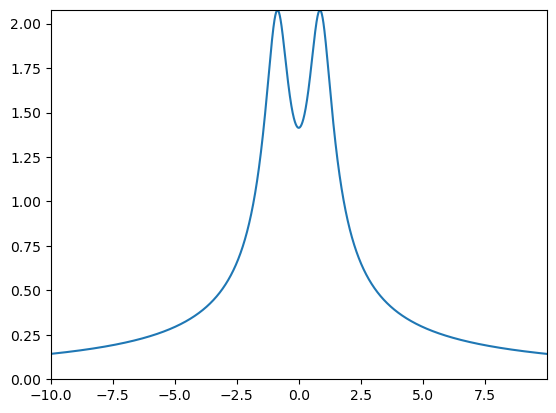

In [5]:
where = np.abs(x) < 10
anim = animate(np.abs(v[:,where]), t, x[where])

In [6]:
HTML(anim.to_jshtml())

In [14]:
E = np.empty(shape=v.shape[0])
for i in tqdm(range(v.shape[0])):
    E[i] = energy(v[i])

  0%|          | 0/100 [00:00<?, ?it/s]

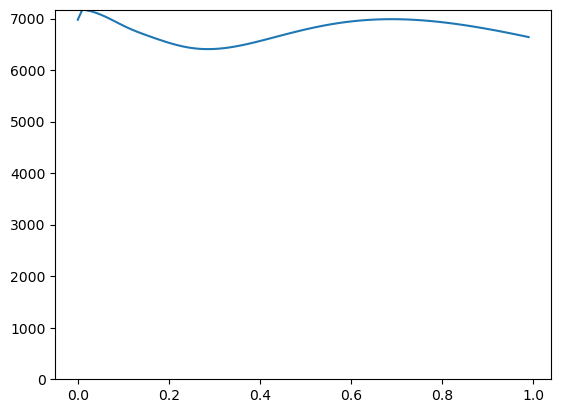

In [15]:
plt.ylim(0, np.max(E))
plt.plot(t, E)
plt.show()